# How to read out simulated data from ppc or clsim & access POCAM geometry

### 1. Import everything necessary:

In [12]:
#icecube:
from icecube import dataio, dataclasses, simclasses
from icecube.icetray import OMKey
from icecube.dataclasses import *

# The usual:
import os
import numpy as np
import copy

#Plotting:
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

### 2. Read in geometry frame:
Read in the GCD file with which the data was produced, to get the OMKeys with coordinates of all DOMs.

In [13]:
geometry = dataio.I3File("/cvmfs/icecube.opensciencegrid.org/data/i3-test-data/sim/GeoCalibDetectorStatus_IC86.55380_corrected.i3.gz")
gframe = geometry.pop_frame()  
geo = gframe["I3Geometry"] #access geo file via key
all_dom_keys = geo.omgeo.keys()

`all_dom_keys` is now a list of all OMKeys. A OMKey contains a DOM number, string number and PMT number.

In [14]:
example_key=all_dom_keys[0]
print example_key
print example_key.om, example_key.string, example_key.pmt

OMKey(1,1,0)
1 1 0


### 3. Create event dictionary
I always read the data into a dictionary with the OMKey as key and the integrated charge and time stamps as value.

In [15]:
event = {} 

for i in all_dom_keys:
    #First element is the number of total hits and the second is a list 
    #of time stamps at which the hits were recorded
    event[i] = [0,[]] 
    #Later this could look like: event[OMKey(36,45,0)] = [3,[1243.5,1432.4,1632.2]]

### 4. Read in data
Now we got an empty event dictionary, which we can make copies from and fill with data.

In [17]:
#As a first step we create a new empty data dictioniary:
data_dict=copy.deepcopy(event)

#Then we read in the i3 file:
data_tmp_i3 = dataio.I3File(os.path.expanduser("/home/fschmuckermaier/data/ppc_test/test_pocam_88_71.i3"))

#Specify the number of frames/simulation runs to pop:
n=100

When reading in the data, we go through all frames and add up the number of hits and time stamps.

In [18]:
for i in range(n): #iterate over framess
    data_tmp_fr = data_tmp_i3.pop_daq() #pop frame
    data_tmp_k = data_tmp_fr['MCPESeriesMap'] #data is stored in 'MCPESeriesMap'
    for c,j in enumerate(data_tmp_k.iteritems()): 
        
        #-----------------------------------------
        #Print very first element as an example:
        if c==0 and i==0:
            print 'Example:'
            print '--------'
            print 'Item:', j
            print ''
            print 'DOMKey:', j[0]
            print ''
            print 'Num. of hits:', len(j[1])
            print ''
            print 'Hit information:'
            print j[1][0] #j[1] is list of individul hit events, j[1][0]
            print ''
            print 'First time stamp:', j[1][0].time, 'ns after flash'
        #-----------------------------------------
        
        dom_key= j[0]
        charge = len(j[1])
        data_dict[dom_key][0] += charge #adding up hits
        data_dict[dom_key][1] += [j.time for j in j[1]] #appending list of time stamps

Example:
--------
Item: (OMKey(10,46,0), [<icecube.simclasses.I3MCPE object at 0x7f5403962c90>])

DOMKey: OMKey(10,46,0)

Num. of hits: 1

Hit information:
[ I3MCPE::
  Time :2952.9
  NPE  :1
  I3ParticleID(0, 0) ]

First time stamp: 2952.89697266 ns after flash


### 5. Plotting time histograms:
Now, we can make histograms with the list of time stamps:

In [22]:
#Define time bins:
time_bins = np.linspace(0,1000,101) 
binsize=time_bins[1]
print 'Binsize:',binsize,'ns'

Binsize: 10.0 ns


In [23]:
#Look at example DOM on string 36:
dom_key=OMKey(36,53,0)

#Define bins:
bins = time_bins
#Bin the time stamps:
array,edges=np.histogram(data_dict[dom_key][1],bins=bins)
#average time bins to counts per run/flash:
time_hist=[m/float(n) for m in array] 

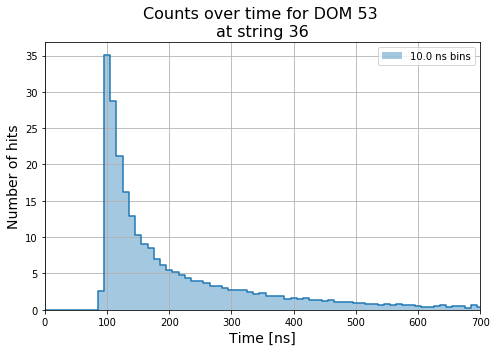

In [24]:
#Plot it:
plt.figure(figsize=(7,5))
plt.step(time_bins[:-1],time_hist,where='mid')
plt.fill_between(time_bins[:-1],time_hist, step="mid", alpha=0.4,label='{} ns bins'.format(binsize))
plt.xlim(0,700)
plt.ylim(0,None)
plt.xlabel('Time [ns]', fontsize=14)
plt.ylabel('Number of hits', fontsize=14)
plt.grid(True)
plt.title('Counts over time for DOM 53 \nat string 36',fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout()

### 6. Averaging data
In case the time information is not relevant and only the mean counts per run are important, the data needs to be averaged to counts per run and mean arrival time: 

Note: To be more realistic, saturated DOMs can be removed, by checking the photocurrent. If the current is higher than 31 photoelectrons per nanosecond, the DOM PMT is saturated and cannot be used for analysis.

In [29]:
for i in all_dom_keys:  #go through all DOMs
    ### Averaging to charge per run ###
    data_dict[i][0] = data_dict[i][0]/float(n)
    
    
    if len(data_dict[i][1]) != 0: #look only at hit DOMs
        bins = np.linspace(0,10000,1001) #bin array in 10ns
        array,edges=np.histogram(data_dict[i][1],bins=bins) #bin hits in 10ns
        if (max(array)/float(n)) < 312:  #curent limit of 50mA (or 312 p.e. per 10ns)
                
            ### Averaging time array to mean arrival time ###
            data_dict[i][1] = np.mean(data_dict[i][1]) 
            
        else: #remove saturated DOMs:
            data_dict[i][0] = 0
            data_dict[i][1] = [0]
    else: #set mean arrival time to 0 for non hit DOMs
        data_dict[i][1] = [0]  

### 7. Plot a single flash event:
Now an average POCAM flash can be plotted in the icecube event style

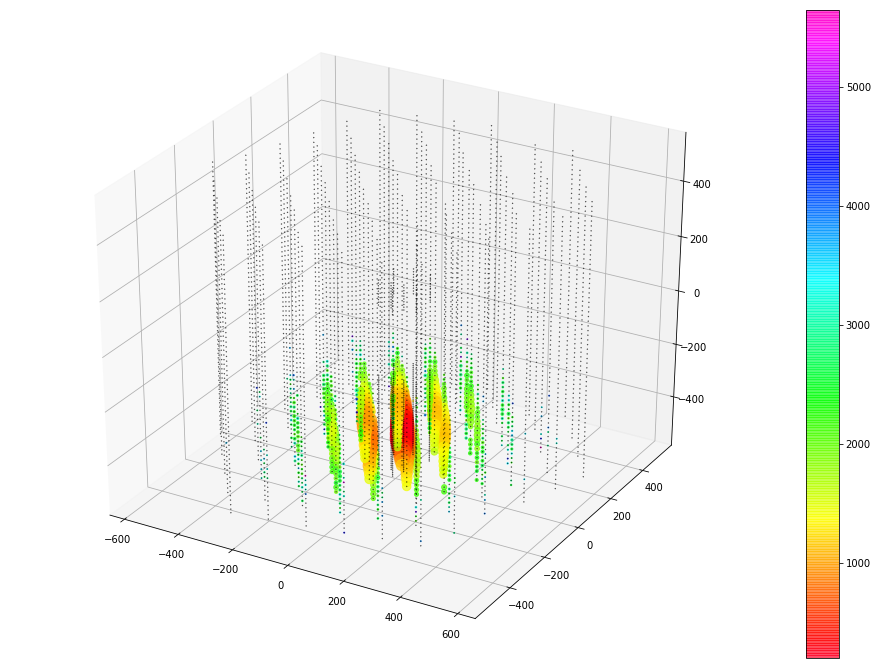

In [30]:
### Then plot ###
fig = plt.figure(figsize=(13,9))
ax = Axes3D(fig)
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

#DOM arrays for plotting DOMs as black dots
x_doms_d=[]
y_doms_d=[]
z_doms_d=[]
#DOM arrays for plotting hit DOMs 
x_doms=[]
y_doms=[]
z_doms=[]
times=[]
sizes=[]

for i in all_dom_keys:
    if geo.omgeo[i].position.z < 500: #Ignore IceTop
        x_doms_d.append(geo.omgeo[i].position.x)
        y_doms_d.append(geo.omgeo[i].position.y)
        z_doms_d.append(geo.omgeo[i].position.z)

    if data_dict[i][0] != 0:
        x_doms.append(geo.omgeo[i].position.x)
        y_doms.append(geo.omgeo[i].position.y)
        z_doms.append(geo.omgeo[i].position.z)
        times.append(data_dict[i][1]) #time as color
        sizes.append(100*np.log(data_dict[i][0]+1)) #counts as size (scaling is arbitrary in this case)

p=ax.scatter(x_doms_d,y_doms_d,z_doms_d,c='k',s=0.1,alpha=1)
p=ax.scatter(x_doms,y_doms,z_doms,c=times,cmap='gist_rainbow',s=sizes,alpha=0.7)
fig.colorbar(p)
plt.show()

### 8. Visualize all POCAM positions
The GCG file `GeoCalibDetectorStatus_ICUpgrade.v55.mixed_mergedGeo.V4.i3.bz2` contains the current positions of all upgrade modules. 

In [5]:
geometry = dataio.I3File("/data/sim/IceCubeUpgrade/geometries/GCDs/GeoCalibDetectorStatus_ICUpgrade.v55.mixed_mergedGeo.V4.i3.bz2")
gframe = geometry.pop_frame()  
geo = gframe["I3Geometry"] #access geo file via key

#Upgrade modules are stored in 'I3ModuleGeoMap':
geo_mod = gframe['I3ModuleGeoMap'] 

all_dom_keys = geo.omgeo.keys()

In [6]:
#Define the POCAM class:
pocam = dataclasses.I3ModuleGeo.POCAM

In [7]:
#POCAM positions:
pocam_keys_dict={}
pocam_keys=[]
print 'Str','OM','x','y','z'
for i in geo_mod.keys():
    if geo_mod[i].module_type == pocam:
        pocam_keys_dict[i.string] = i
        pocam_keys.append(i)
        print i.string,i.om,geo_mod[i].pos.x,geo_mod[i].pos.y,geo_mod[i].pos.z

Str OM x y z
87 4 18.3 -51.1 348.07
87 84 18.3 -51.1 -421.93
88 2 47.3 -57.0 398.07
88 72 47.3 -57.0 -385.93
89 2 14.3 -80.6 548.07
89 10 14.3 -80.6 298.07
89 13 14.3 -80.6 173.07
89 38 14.3 -80.6 -277.93
89 107 14.3 -80.6 -546.93
90 12 57.3 -83.7 298.07
90 14 57.3 -83.7 248.07
90 100 57.3 -83.7 -457.93
91 15 89.3 -59.0 123.07
91 50 89.3 -59.0 -313.93
92 6 62.6 -35.2 398.07
92 18 62.6 -35.2 -101.93
92 28 62.6 -35.2 -241.93
93 8 27.0 -31.2 348.07
93 17 27.0 -31.2 -76.93
93 64 27.0 -31.2 -349.93
93 113 27.0 -31.2 -646.93


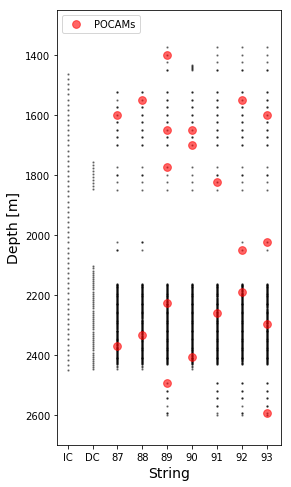

In [8]:
fig = plt.figure(figsize=(4,8))

x_doms_d=[]
y_doms_d=[]
z_doms_d=[]
x_doms_p=[]
y_doms_p=[]
z_doms_p=[]
for i in all_dom_keys:
    if geo.omgeo[i].position.z < 500:
        if i.pmt==0 and i.string > 86:
            x_doms_d.append(i.string)
            z_doms_d.append(1948.07-geo.omgeo[i].position.z)
        if i.string == 86:
            x_doms_d.append(i.string)
            z_doms_d.append(1948.07-geo.omgeo[i].position.z)
        if i.string == 77:
            x_doms_d.append(85)
            z_doms_d.append(1948.07-geo.omgeo[i].position.z)
    
for i in geo_mod.keys():
    if i.string > 86:
        x_doms_d.append(i.string)
        z_doms_d.append(1948.07-geo_mod[i].pos.z)
    
    if geo_mod[i].module_type == pocam:
        x_doms_p.append(i.string)
        z_doms_p.append(1948.07-geo_mod[i].pos.z)
    
        
plt.scatter(x_doms_d,z_doms_d,c='k',s=7,alpha=0.4,marker='.')
plt.scatter(x_doms_p,z_doms_p,c='r',label='POCAMs',s=60,alpha=0.6,marker='o')
plt.xlabel('String',fontsize=14)
plt.ylabel('Depth [m]',fontsize=14)
my_xticks = ['IC','DC',87,88,89,90,91,92,93]
x=range(85,94)
plt.xticks(x, my_xticks)
rcParams['axes.labelpad'] =12
plt.ylim(2700,1250)
plt.legend(loc='upper left')
#plt.savefig('pocam_positions_2d.pdf',bbox_inches='tight')
plt.show()

In [9]:
#Upgrade string positions:
for i in geo_mod.keys():
    if i.string>86:
        if i.om==1:
            print i.string,':',geo_mod[i].pos.x,geo_mod[i].pos.y

87 : 18.3 -51.1
88 : 47.3 -57.0
89 : 14.3 -80.6
90 : 57.3 -83.7
91 : 89.3 -59.0
92 : 62.6 -35.2
93 : 27.0 -31.2


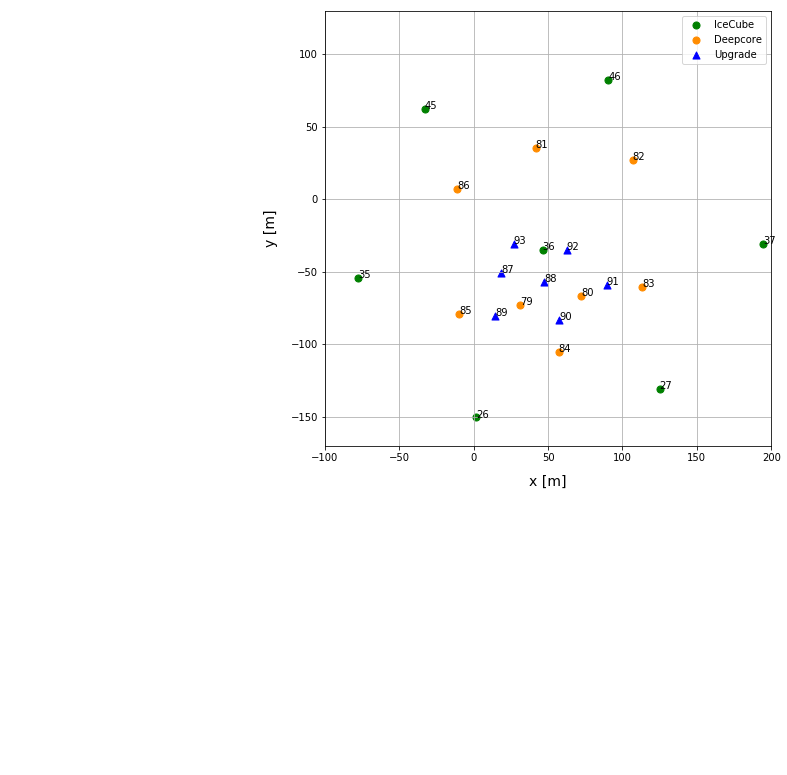

In [10]:
#Plotting the drill hole positions of IC,DC and upgrade:
fig = plt.figure(figsize=(8,8))

deepcore_keys=[OMKey(80,52,0),OMKey(81,52,0),OMKey(82,52,0),OMKey(83,52,0),OMKey(84,52,0),OMKey(85,52,0),OMKey(86,52,0),OMKey(79,52,0)]

# IceCube #
x_doms=[]
y_doms=[]
for i in all_dom_keys:
    if i.string < 79 and geo.omgeo[i].position.z<100 and i.om==50 and geo.omgeo[i].position.x <200 and geo.omgeo[i].position.x>-250 and geo.omgeo[i].position.y <100 and geo.omgeo[i].position.y>-250:
        x_doms.append(geo.omgeo[i].position.x)
        y_doms.append(geo.omgeo[i].position.y)
        plt.annotate(i.string, (geo.omgeo[i].position.x,geo.omgeo[i].position.y))
plt.scatter(x_doms,y_doms,c='g',s=50,label='IceCube',marker='o')   

# DeepCore #
x_doms_d=[]
y_doms_d=[]
for i in all_dom_keys:
    if i.string > 78 and i.string <87 and geo.omgeo[i].position.z<100 and i.pmt==0  and i.om==20:
        x_doms_d.append(geo.omgeo[i].position.x)
        y_doms_d.append(geo.omgeo[i].position.y)
        plt.annotate(i.string, (geo.omgeo[i].position.x,geo.omgeo[i].position.y))
plt.scatter(x_doms_d,y_doms_d,c='darkorange',s=50,label='Deepcore',marker='o')

# Upgrade #
upgrade_keys=[pocam_keys_dict[87],pocam_keys_dict[88],pocam_keys_dict[89],pocam_keys_dict[90],pocam_keys_dict[91],pocam_keys_dict[92],pocam_keys_dict[93]]
x_doms_u=[]
y_doms_u=[]
for i in upgrade_keys:
        x_doms_u.append(geo_mod[i].pos.x)
        y_doms_u.append(geo_mod[i].pos.y)
        plt.annotate(i.string, (geo_mod[i].pos.x,geo_mod[i].pos.y))
plt.scatter(x_doms_u,y_doms_u,c='b',s=50,label='Upgrade',marker='^')

plt.grid(True)
plt.xlabel('x [m]',fontsize=14)
plt.ylabel('y [m]',fontsize=14)
plt.xlim(-100,200)
plt.ylim(-170,130)
plt.legend()
#plt.savefig('upgrade_positions.pdf')